# The Business Challenge


## The Cardio Catch Disease Company

### Cardiovascular Diagnosis

### Current Situation:

     The price of diagnosis varies according to the precision achieved by the specialists.


- Manual diagnosis with precision between 55% and 65%
- Diagnosis cost: BRL 1.000.00
- Customers pays BRL 500.00 for each 5% precision above 50%
- Diagnosis with 55 precision - customers pays BRL 500.00
- Diagnosis with 60% precision - customers pays BRL 1.000.00
- Diagnosis with only 50% precision - customers does not pay


### Problem:
    The different values in the precision affect the costs. This uncertanty scenarium makes the company unpredictable cashflow.
    
### Goal:

    Create a tool that increases the diagnosis precision with stable precision for all diagnosis.

### Deliverables:

    A tool that classifies the presence or absence of cardiovascular disease, with a stable precision.

    Report for the Cardio Catch Disease's CEO, with the results and answer to the following questions:

1. What is the tool's accuracy and precision?

2. How much profit will the new tool provide to Cardio Catch Disease?

3. What is the new tool's reliability (confidence interval)?



## Features (Columns) Description

    Data description source: 
    https://www.kaggle.com/sulianova/cardiovascular-disease-dataset?select=cardio_train.csv

There are 3 types of input features:

    Objective - factual information:
        Age (days);
        Height (cm);
        Weight (kg);
        Gender (categorical code).

    Examination - results of medical examination:
        Systolic blood pressure (ap_hi);
        Diastolic blood pressure (ap_lo);
        Cholesterol (cholesterol - 1: normal, 2: above normal, 3: well above normal);
        Glucose (gluc - 1: normal, 2: above normal, 3: well above normal).

    Subjective - information given by the patient:
        Smoking (smoke - binary);
        Alcohol intake (alco - binary);
        Physical Activity (active - binary).

    Target Variable:
        Presence or absence of cardiovascular disease (cardio - binary).

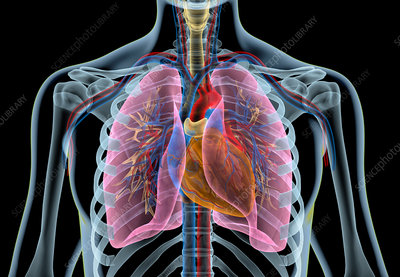

In [34]:
Image( 'human_chest.png', width=1200)

In [35]:
# data manipulation
import pandas as pd
import numpy  as np

# EDA
import matplotlib.pyplot as plt
import seaborn           as sns

# Algorithms
import xgboost as xgboost
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble      import RandomForestRegressor



import inflection 
import math
import nbextensions
import datetime
import random
import warnings
warnings.filterwarnings( 'ignore' )


from scipy                 import stats as ss
from IPython.core.display  import HTML 
from IPython.display       import Image

from sklearn.metrics       import mean_absolute_error
from sklearn.metrics       import mean_squared_error
from sklearn.metrics       import mean_absolute_percentage_error 

from sklearn.linear_model  import Lasso
from sklearn.linear_model  import LinearRegression


from boruta                import BorutaPy



import matplotlib.gridspec as gridSpec

In [36]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data:

In [37]:
df_raw = pd.read_csv( 'cardio_train.csv', sep=';' )

In [38]:
df_raw.sample()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
45666,65223,22688,1,164,86.0,140,60,2,1,0,0,1,1


# PASSO 01 - DATA DESCRIPTION

In [39]:
df1 = df_raw.copy()

In [40]:
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Rename Columns

In [41]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [42]:
cols_old = ( [ 'id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio' ] )


snakecase = lambda x: inflection.underscore( x )

cols_new = list( map(snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [43]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

## Data Dimensions

In [44]:
print ( 'Number of Rows: {}'.format( df1.shape[0] ) )
print ( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 70000
Number of Cols: 13


## Data Types:

In [45]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## Check 'NAs'

In [46]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [47]:
df1.sample(5).T

,10520,57809,23419,68650,56276
id,15022.0,82496.0,33457.0,98075.0,80293.0
age,19241.0,23213.0,23167.0,17481.0,16675.0
gender,1.0,1.0,1.0,2.0,1.0
height,151.0,164.0,154.0,158.0,160.0
weight,57.0,76.0,80.0,61.0,53.0
ap_hi,100.0,160.0,136.0,120.0,100.0
ap_lo,70.0,100.0,90.0,80.0,60.0
cholesterol,1.0,1.0,3.0,1.0,2.0
gluc,1.0,1.0,3.0,1.0,1.0
smoke,0.0,0.0,0.0,0.0,0.0


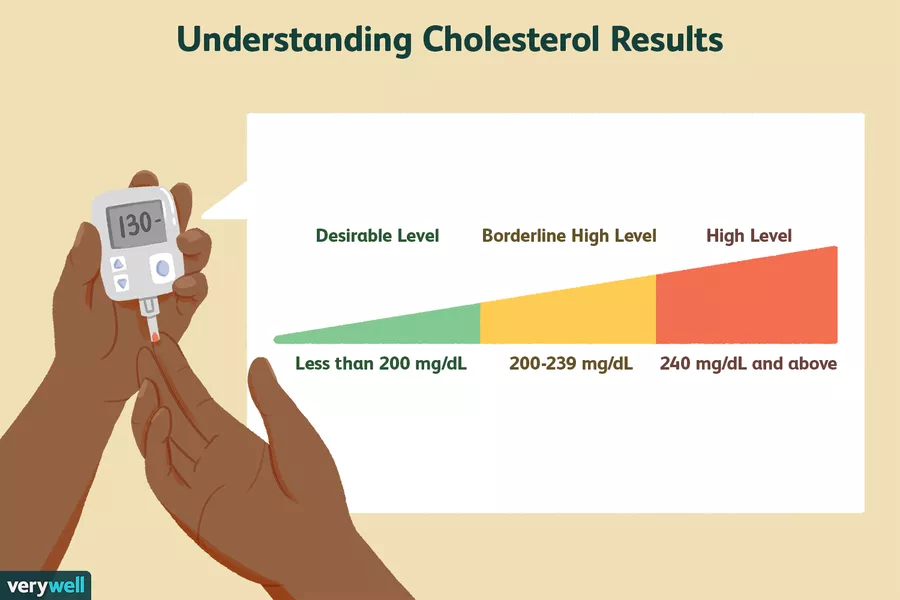

In [48]:
Image( 'cholesterol.png', width=1000 )

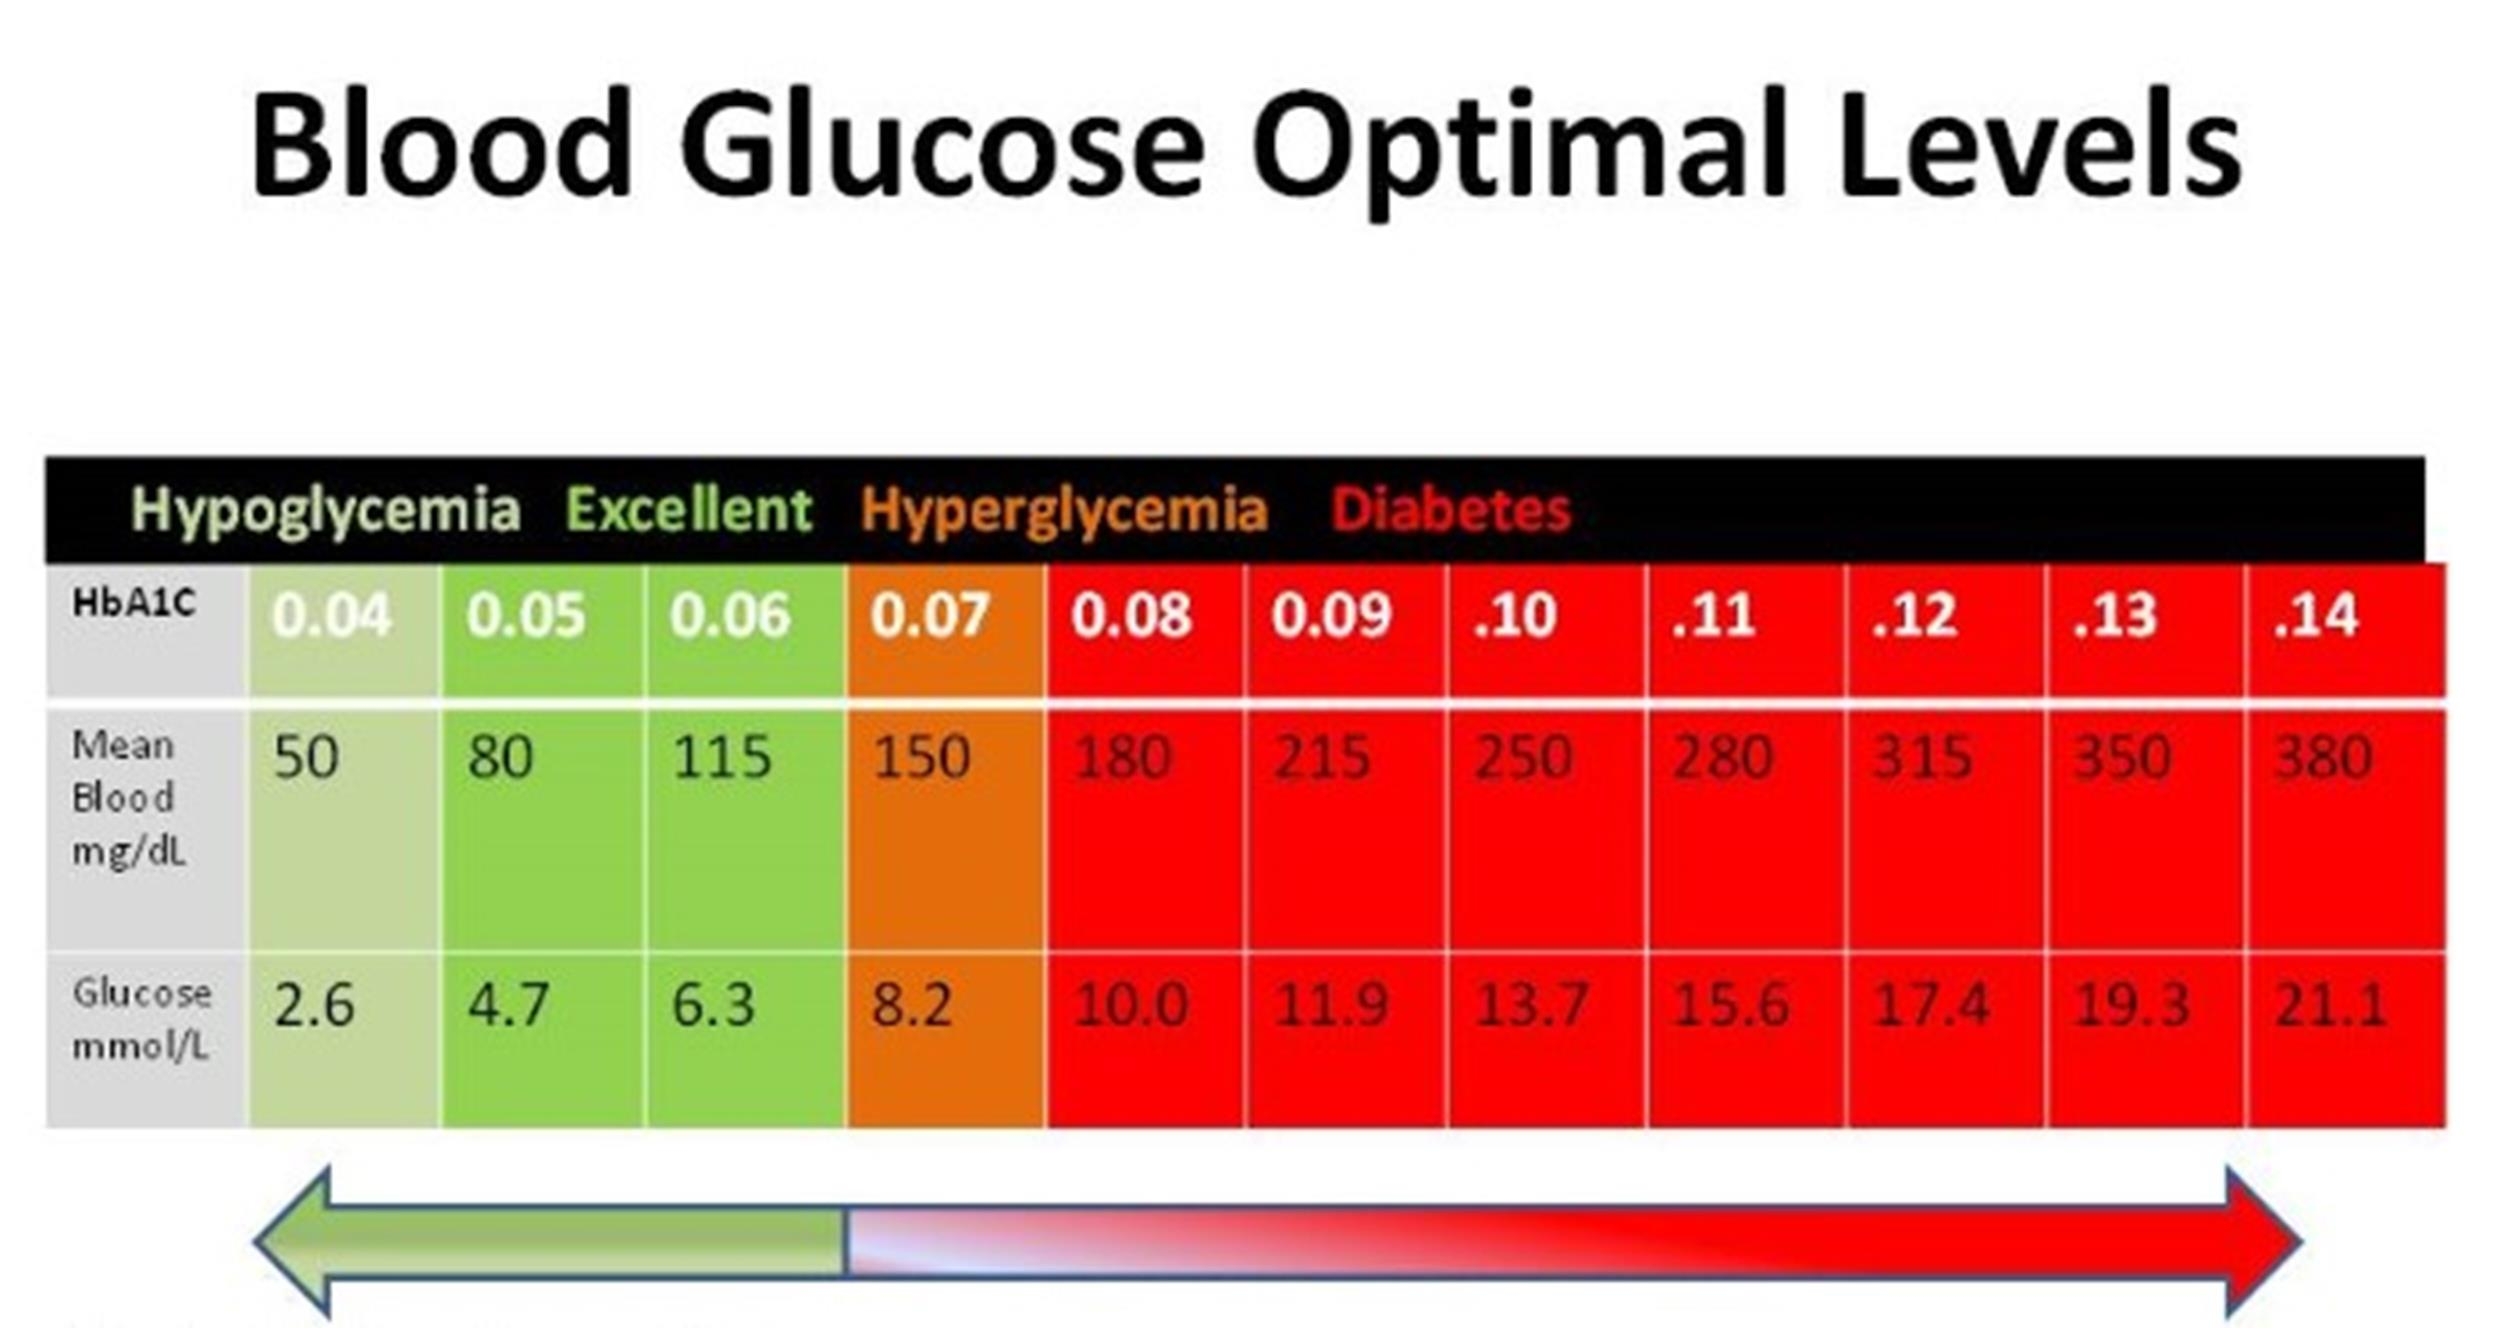

In [49]:
Image( 'glucose.png', width=1000 )

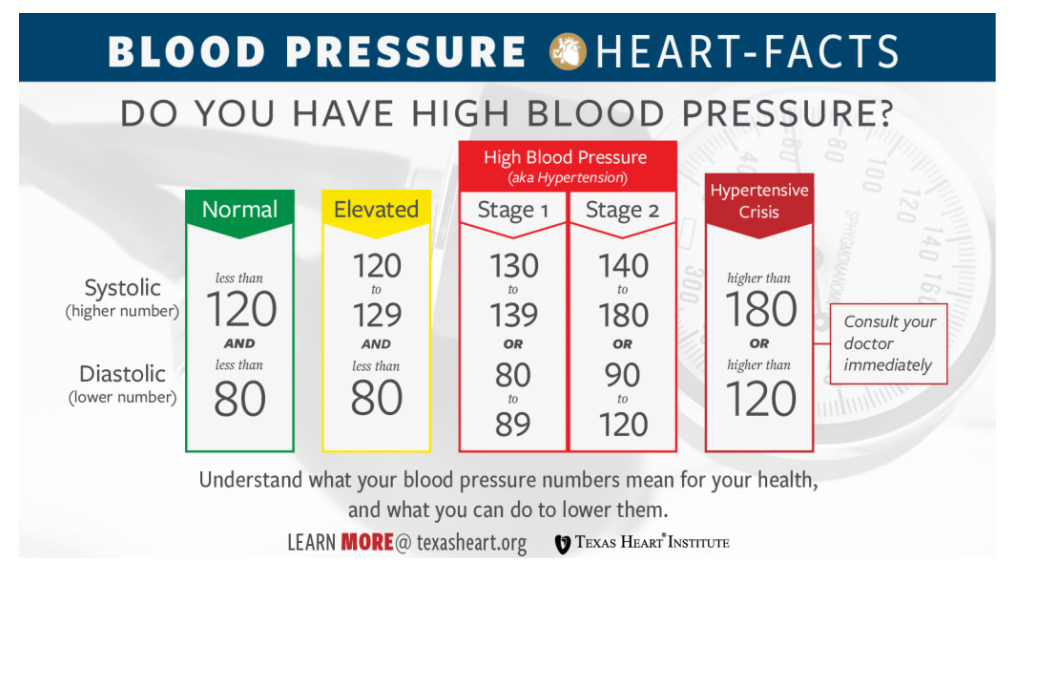

In [50]:
Image( 'blood_pressure_levels.png', width=10000 )

In [51]:
# age
df1[ 'age' ] = df1[ 'age' ].apply( lambda x: x/365 )
df1[ 'age' ] = round(df1[ 'age' ], 0).astype( int )

# gender
df1[ 'gender' ] = df1[ 'gender' ].apply( lambda x: 'female' if x==1 else 'male' )

# cholesterol
cholesterol = {1:'desirable', 2:'borderline', 3:'high' }
df1[ 'cholesterol' ] = df1[ 'cholesterol' ].map( cholesterol )

# glucose
gluc = { 1:'normal', 2:'above_normal',3:'well_above_normal' }
df1[ 'gluc' ] = df1[ 'gluc' ].map( gluc )

# smoke
df1[ 'smoke' ]= df1[ 'smoke' ].apply( lambda x: 'yes' if x==1 else 'no' )

# alco
df1[ 'alco' ] = df1[ 'alco' ].apply( lambda x: 'yes' if x==1 else 'no')

# active
df1[ 'active' ] = df1[ 'active' ].apply( lambda x: 'yes' if x==1 else 'no')

# cardio
df1[ 'cardio' ] = df1[ 'cardio' ].apply( lambda x: 'yes' if x==1 else 'no')


## Descriptive Statistical

In [52]:
# This point of process aims to summarize of data, worrying about fewer variations and intervals.

# Numerical variables
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64' ] )

# Categorical variable
cat_attributes = df1.select_dtypes( exclude = [ 'int64', 'float64'] )

In [53]:
num_attributes.sample(2)

,id,age,height,weight,ap_hi,ap_lo
6162,8773,64,154,95.0,130,80
63898,91233,56,174,88.0,120,80


In [54]:
cat_attributes.sample(2)

,gender,cholesterol,gluc,smoke,alco,active,cardio
44727,male,desirable,above_normal,no,no,no,yes
32776,male,desirable,normal,no,no,yes,no


## Numerical Atributes

In [55]:
# Central tendency - mean, median:


ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# Dispersion - std, min, max, range, skew, kurtosis:


d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
                  
# Concatenation of variables:
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = [ 'attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    
# Sumary of statistics
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,30.0,65.0,35.0,53.338686,54.0,6.765246,-0.306444,-0.821815
2,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
3,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
4,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
5,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585


 - Min age    is 30 and min height is 55cm?
 - Max height is 250 cm?
 
 - Diastolic max is 11.000?
 - Systolic  max is 16.000?


- People are ( 30 - 65 ) years old; with 53 years as mean and 54 years as median; those measurements looks like as normal distribution.


- The people height are (55 cm - 250 cm ), with average of 164cm; apparently someone on the list have  abnormality, because the minimum of height range.


- The people weight are (10 kg - 200 kg ), with average of 74kg; apparently someone on the list have abnormality; because the youngest is 30, and 10kg looks like children weight.


- Diastolic pressure range ( -150 160.000 )


- Systolic pressure range ( -70 11.000 )


## Categorical Atrributes

In [56]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender         2
cholesterol    3
gluc           3
smoke          2
alco           2
active         2
cardio         2
dtype: int64

<AxesSubplot:xlabel='cardio', ylabel='age'>

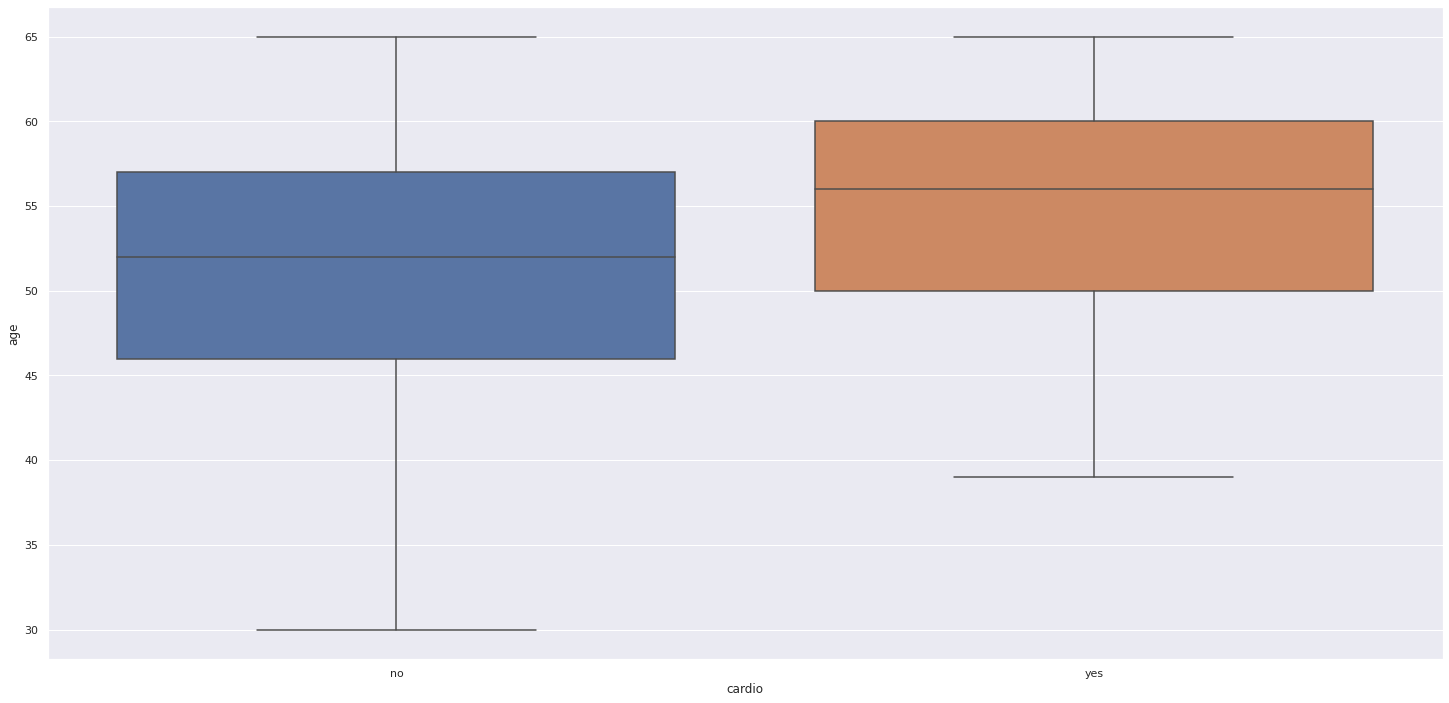

In [57]:
# Plotting of categorical variables 

# cardio x age

sns.boxplot(x='cardio', y='age', data=df1 )

### Observations (Cardio x Age ):

- The patients age with cardiovascular disease is range 38 to 65 years, with median 55 years.
- The patients age without cardiovascular disease is range 30 to 65, with median under 55 years old.

<AxesSubplot:xlabel='cardio', ylabel='height'>

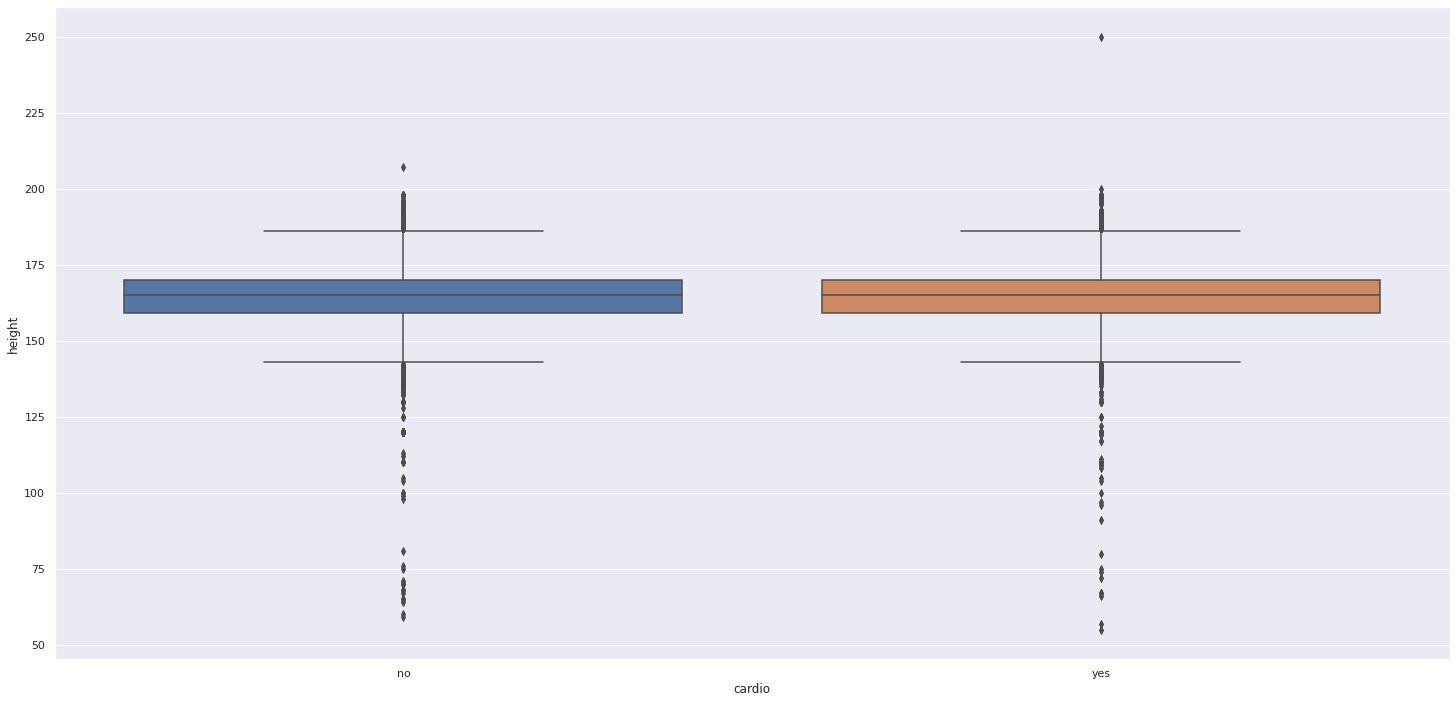

In [58]:
# cardio x height

sns.boxplot( x='cardio', y='height', data= df1 )

### Observations ( Cardio x Height )

- The height range of people with or without cardiovascular disease is similar, then any significant insight can be caught it. 


<AxesSubplot:xlabel='cardio', ylabel='weight'>

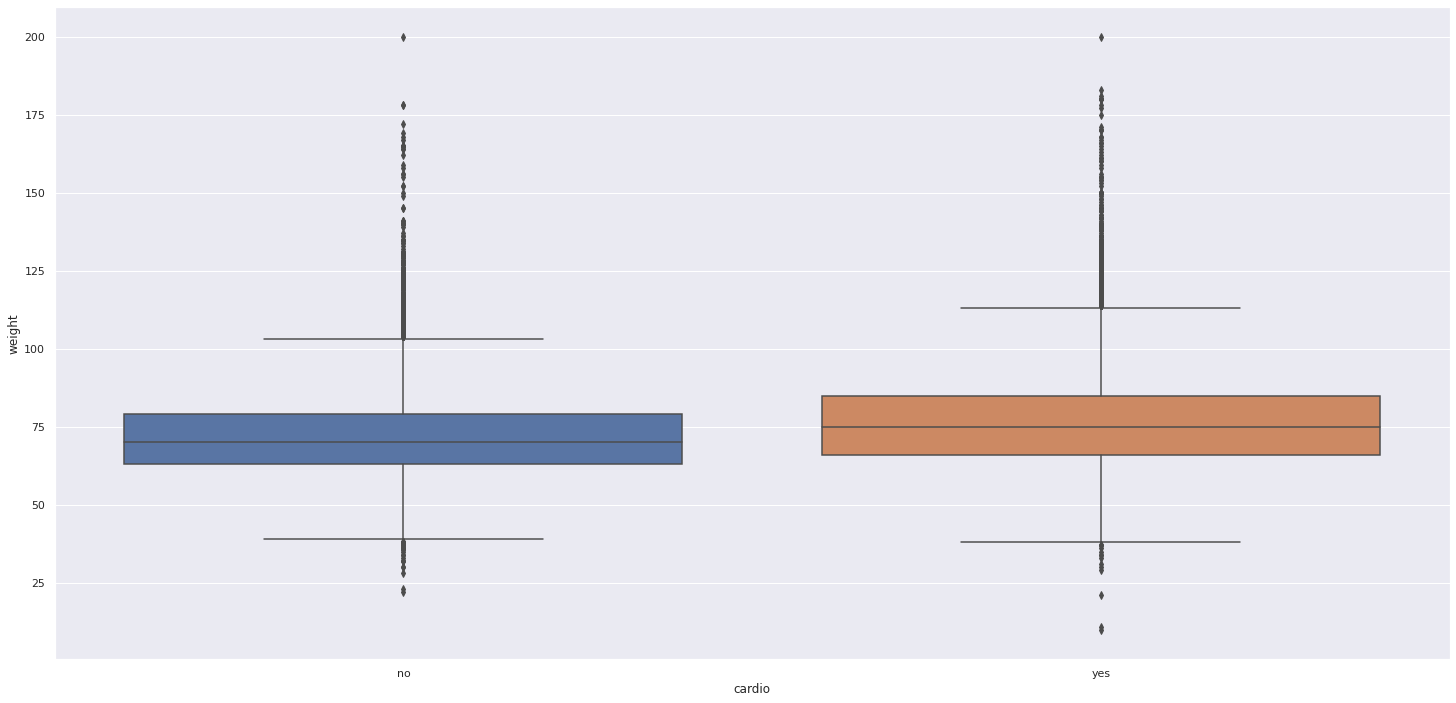

In [59]:
# cardio x weight

sns.boxplot( x='cardio', y='weight', data=df1 )

### Observations ( Cardio x Weight )

- The weight range of cardiovascular disease patients is greater than the weight range of patients without disease.

# cholesterol x age

sns.boxplot( x='cholesterol', y='age', data=df1 )

<AxesSubplot:xlabel='cholesterol', ylabel='height'>

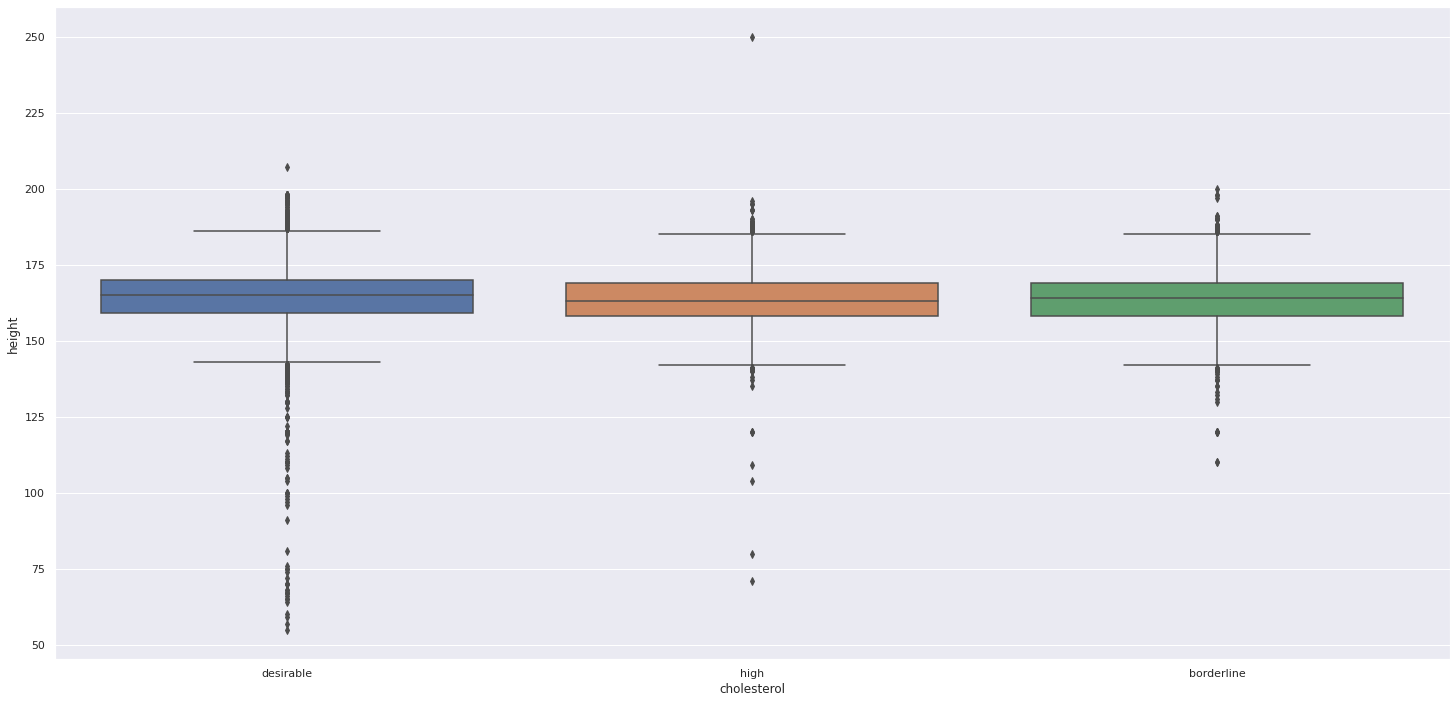

In [62]:
# cholesterol x height

sns.boxplot( x='cholesterol', y='height', data=df1 )

### Observations ( Cholesterol x Age )
 - The range of cholesterol level for all patients with or without cardiovascular are similar, although the age range 50 to 60 years old have more patients with cholesterol well above normal.
    
    

<AxesSubplot:xlabel='cholesterol', ylabel='weight'>

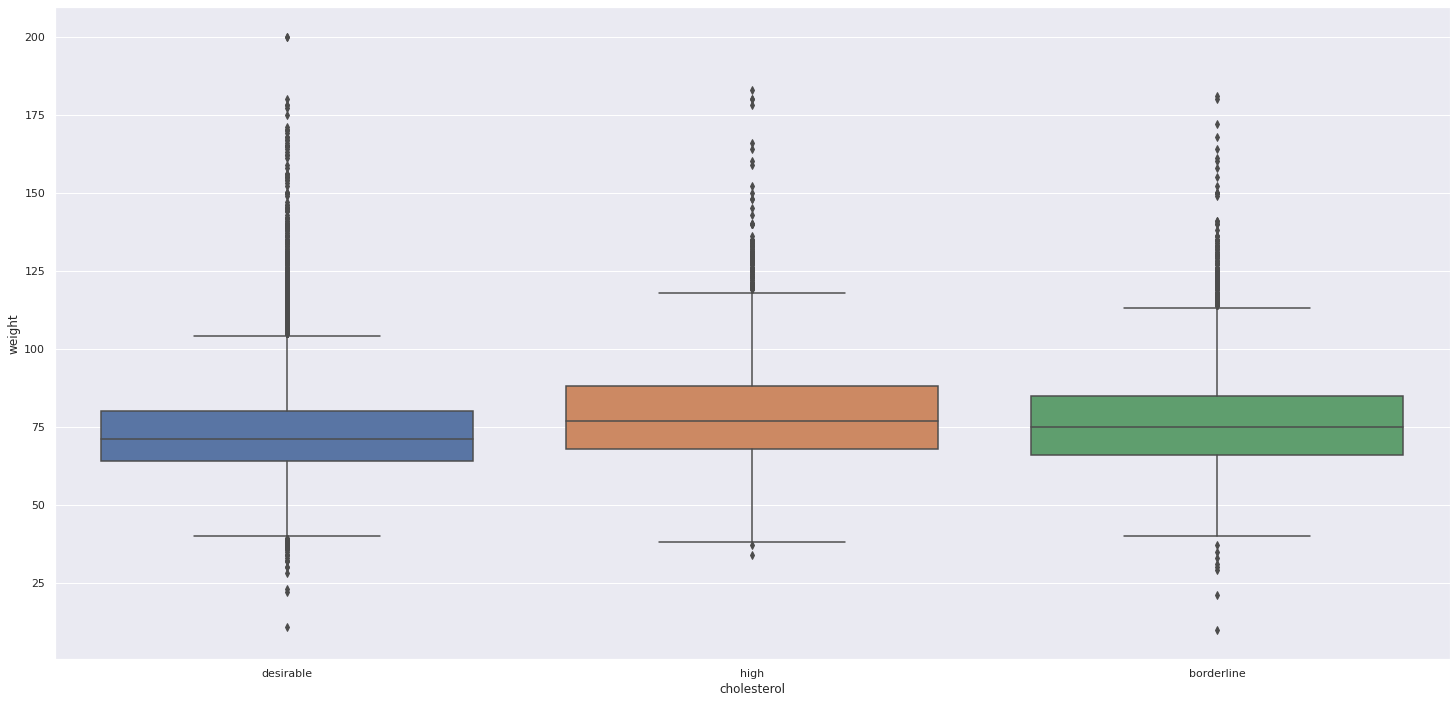

In [42]:
# cholesterol x weight

sns.boxplot( x='cholesterol', y='weight', data=df1 )

<AxesSubplot:xlabel='gluc', ylabel='age'>

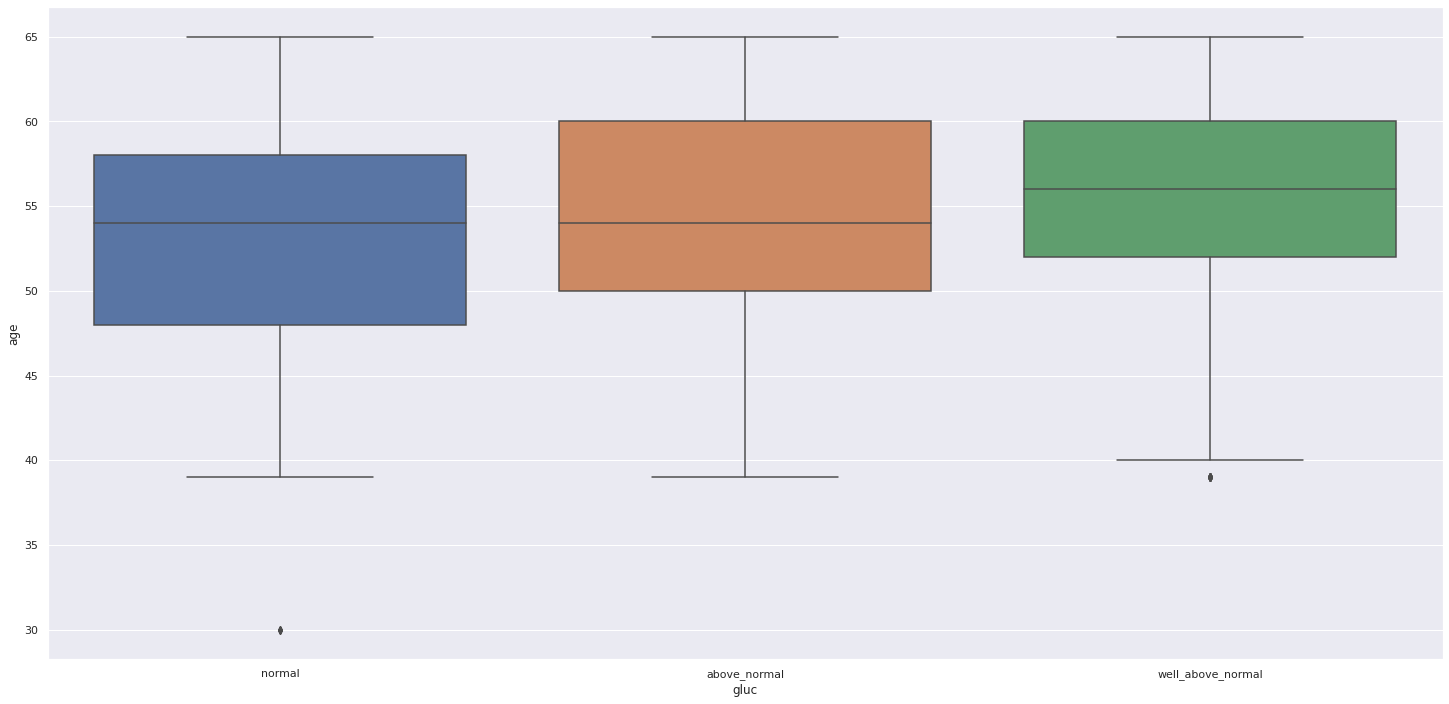

In [43]:
# glucose x age

sns.boxplot(x='gluc', y='age', data=df1 )

<AxesSubplot:xlabel='gluc', ylabel='height'>

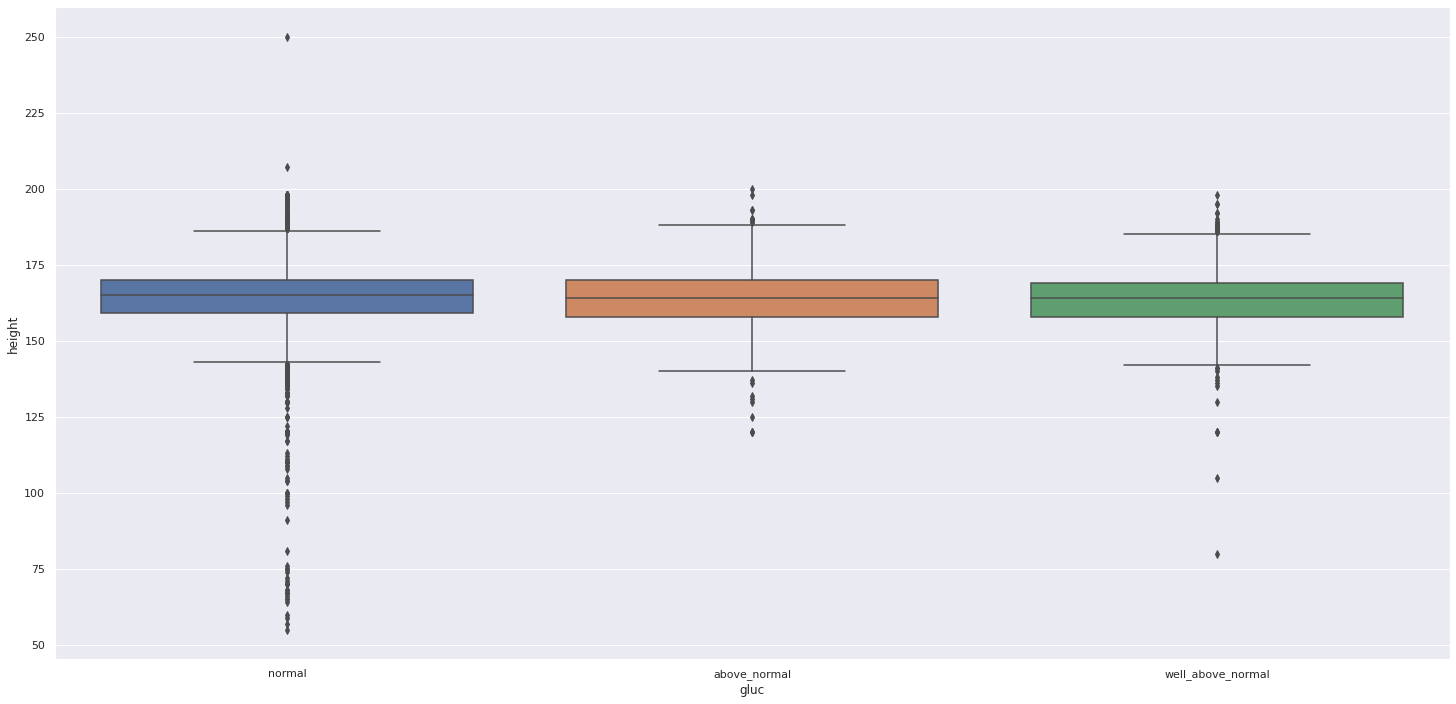

In [45]:
# glucose x height

sns.boxplot( x='gluc', y='height', data=df1 )

<AxesSubplot:xlabel='gluc', ylabel='weight'>

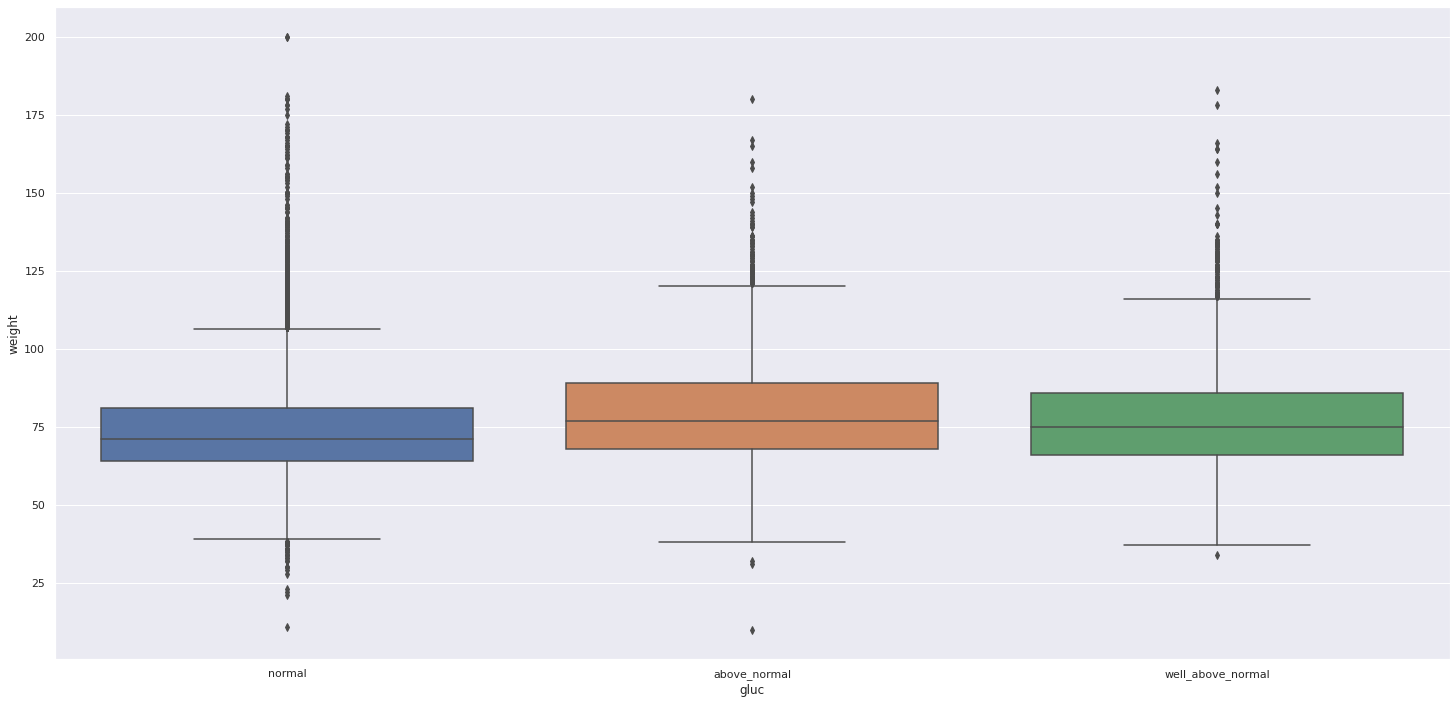

In [46]:
# glucose x weight

sns.boxplot( x='gluc', y='weight', data=df1 )

<AxesSubplot:xlabel='cardio', ylabel='weight'>

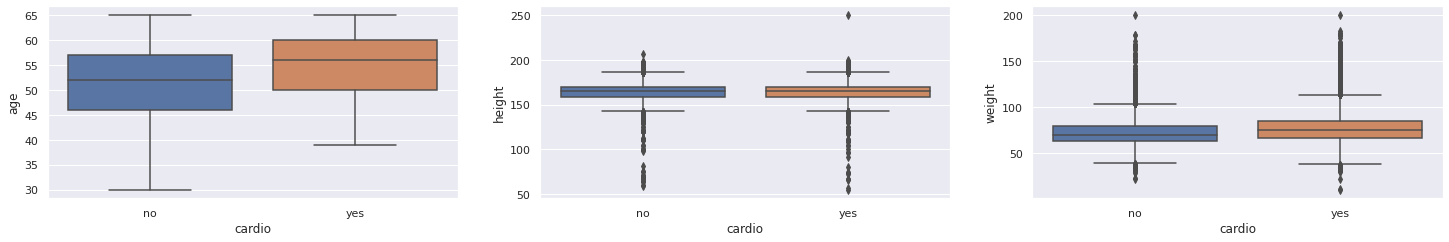

In [59]:
# cardio


plt.subplot( 3, 3, 1 )
gr = sns.boxplot(x='cardio',  y='age',    data=df1 )

plt.subplot( 3, 3, 2 )
sns.boxplot( x='cardio', y='height', data= df1 )

plt.subplot( 3, 3, 3 )
sns.boxplot( x='cardio', y='weight', data=df1 )

<AxesSubplot:xlabel='cholesterol', ylabel='weight'>

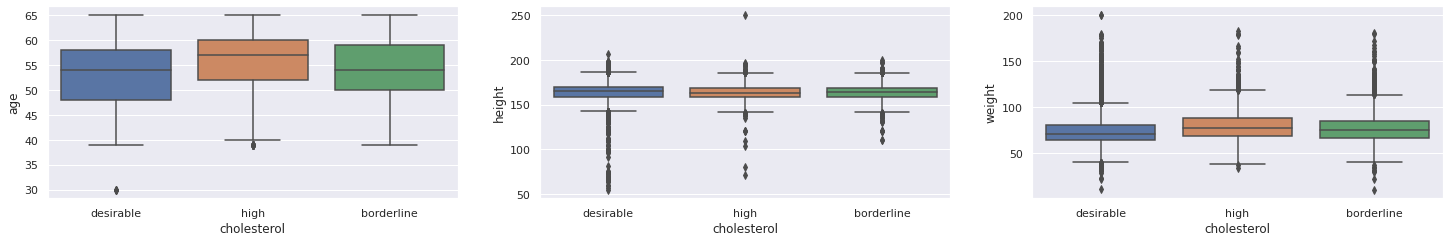

In [50]:
# 'cholesterol'

plt.subplot( 3, 3, 1 )
sns.boxplot( x='cholesterol', y='age',    data=df1 )

plt.subplot( 3, 3, 2 )
sns.boxplot( x='cholesterol', y='height', data=df1 )

plt.subplot( 3, 3, 3 )
sns.boxplot( x='cholesterol', y='weight', data=df1 )


<AxesSubplot:xlabel='gluc', ylabel='weight'>

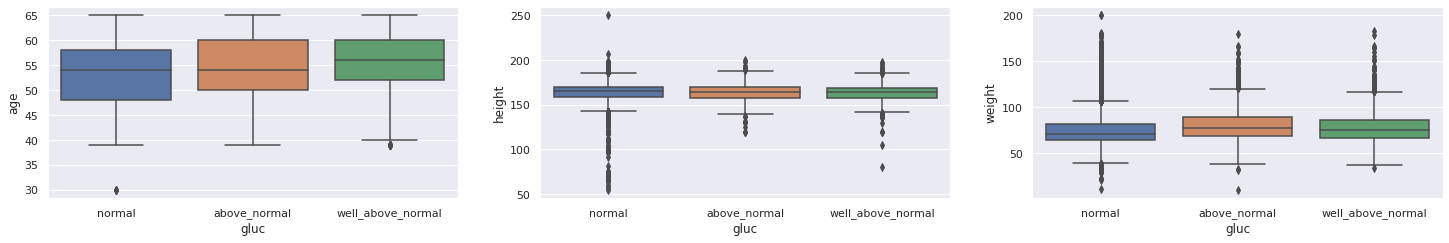

In [52]:
# 'glucose'

plt.subplot( 3, 3, 1 )
sns.boxplot( x='gluc', y='age',    data=df1 )

plt.subplot( 3, 3, 2 )
sns.boxplot( x='gluc', y='height', data=df1 )

plt.subplot( 3, 3, 3 )
sns.boxplot( x='gluc', y='weight', data=df1 )